In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import time

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("white")
%matplotlib inline

import scipy
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix

from sklearn import tree
from IPython.display import Image
import pydotplus
import graphviz

This notebook uses decision trees and the random forest classifier to predict property crime in Los Angeles policing districts.

The dataset is comprised of LA crime data from 2015 to 2017 provided by the Los Angeles Police Department.

Link to the data source:

https://catalog.data.gov/dataset/crime-data-from-2010-to-present

Further reference:
http://maps.latimes.com/neighborhoods/violent-crime/neighborhood/list/

### Read data set file and parse datetime values

In [2]:
df = pd.read_csv('la_2015.csv', parse_dates=['datetime'])

In [3]:
df = df.set_index('datetime')
df.index = df.index.round('H')
df = df.dropna()
# Drop duplicate rows:
df.drop_duplicates(inplace=True)
df.head()

,district,crime_code
datetime,,
2015-01-16 22:00:00,938,510
2015-03-11 16:00:00,143,442
2015-03-23 18:00:00,185,310
2015-03-29 08:00:00,111,510
2015-06-08 10:00:00,144,850


### Rank each district according to the number of reported policing events occured in the period
The districts with more policing events have higher rankings (from 0.00 up to 1.00).

In [4]:
# Create a dataframe ranking districts by crime frequency:
ranking = pd.DataFrame()
ranking['counts'] = df .district.value_counts()
ranking['rank'] = ranking.counts.rank(pct=True)
ranking['rank'] = ranking['rank'].round(decimals=2)

# Create a dictionary with district IDs and ranks:
rank_dict = dict(zip(ranking.index, ranking['rank']))

# Create a column in the df  dataframe with the district rankings:
df['district_ranking'] = np.nan
for key, value in rank_dict.items():
    df.loc[(df['district'] == key),['district_ranking']] = value

#### Filtering districts with higher rankings can improve prediction scores by 0.01 to 0.03 points
For this run, we will not filter districts and run on the entire data set.

In [ ]:
# Optionally, filter districts by their ranking:
# df = df[df.district_ranking>.8]

In [5]:
# Create year, week, and weekday categorical columns:
df['year'] = df.index.year
df['week'] = df.index.week
df['weekday'] = df.index.weekday
df['hour'] = df.index.hour

### Create crime categories columns

Crimes were grouped according to four categories:
1. violent crime
2. personal crime
3. property crime
4. other crime and misdemeanors

In [6]:
# Read file with categories (from 1 to 4) according to crime types:
cats = pd.read_excel('LA_crime_categories.xlsx',skiprows=4)

# Read the categories dataframe and create a dictionary with crime codes and categories:
crime_codes_dict = dict(zip(cats['Crime Code'], cats['category']))

# Create a column with event categories:
df['category'] = np.nan
for key, value in crime_codes_dict.items():
    df.loc[(df['crime_code'] == key), ['category']] = value

# Create the dummy data on a separate dataframe and concatenate with df:
dfCC = pd.get_dummies(df.category)

frames = [df,dfCC]
df = pd.concat(frames, axis=1)

df.drop(columns=['category','crime_code'],inplace=True)

In [7]:
df.head()

,district,district_ranking,year,week,weekday,hour,1.0,2.0,3.0,4.0
datetime,,,,,,,,,,
2015-01-16 22:00:00,938,0.47,2015,3,4,22,0,0,1,0
2015-03-11 16:00:00,143,0.30,2015,11,2,16,0,0,1,0
2015-03-23 18:00:00,185,0.90,2015,13,0,18,0,0,1,0
2015-03-29 08:00:00,111,0.98,2015,13,6,8,0,0,1,0
2015-06-08 10:00:00,144,0.25,2015,24,0,10,0,0,0,1


### Inspect variable correlation

In [8]:
# Generate correlation matrix:
corr_matrix = df.corr()

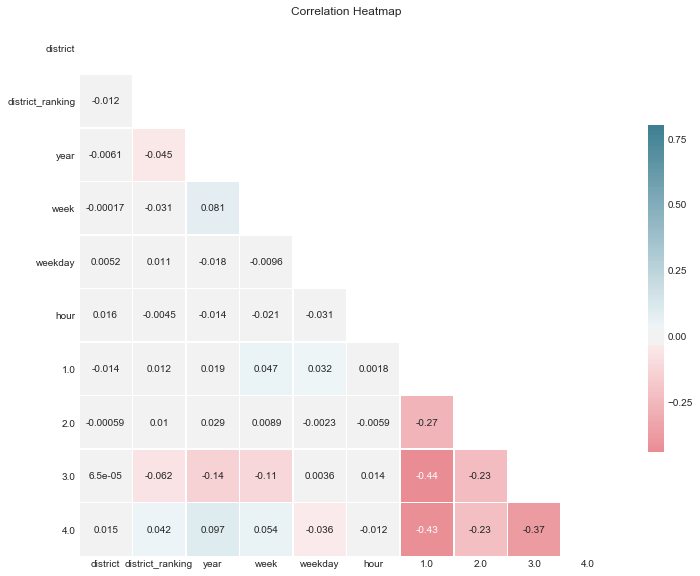

In [9]:
# Create a correlation heatmap
# Generate a mask for the upper triangle
mask = np.zeros_like(corr_matrix,dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(12, 12))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(10, 220, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_matrix,
            mask=mask, cmap=cmap, vmax=.8, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5},annot=True)
plt.title('Correlation Heatmap')
plt.show()

Although crime variables have some correlation between themselves, there is little to no correlation between the crime variables, and the location and time variables.

### Split data to train and test subsets

In [10]:
df_train = df[(df.year < 2017)]
df_test = df[df.year == 2017]

## Run the decision tree and random forest classifier

#### Starting with the single decision tree:

--- 0.022744178771972656 seconds to fit ---
--- 0.0028307437896728516 seconds to predict ---




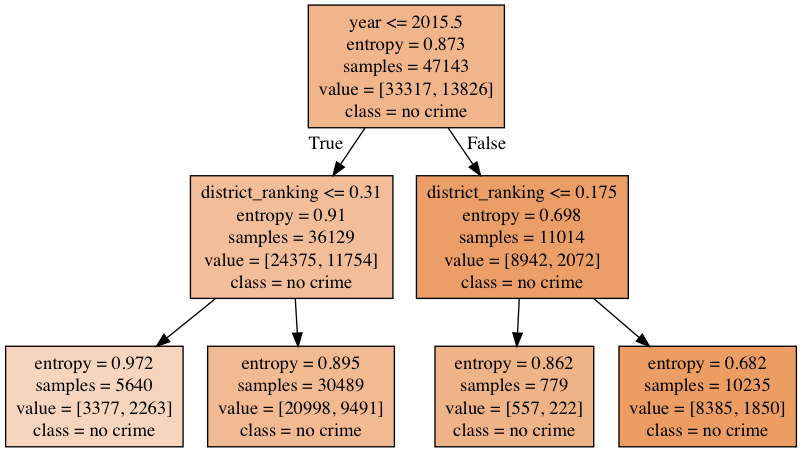

In [11]:
# Initialize and train the decision tree.
start_time = time.time()
decision_tree = tree.DecisionTreeClassifier(
    criterion='entropy',
    max_features=2,
    max_depth=2
)
decision_tree.fit(df_train[['year','week','weekday','hour','district_ranking']],
                  df_train[[3.0]])
print("--- %s seconds to fit ---" % (time.time() - start_time))

# Render the tree.
start_time = time.time()
dot_data = tree.export_graphviz(
    decision_tree, out_file=None,
    feature_names=['year','week','weekday','hour','district_ranking'],
    class_names=['no crime', 'crime'],
    filled=True)
print("--- %s seconds to predict ---\n" % (time.time() - start_time))

graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

#### Random forest classifier:

In [12]:
# Set the start time: 
start_time = time.time()

# Fit the classifier:
clf = RandomForestClassifier(n_estimators=30)
clf.fit(df_train[['year','week','weekday','hour','district_ranking']],
        df_train[[3.0]])

# Set and view the end time:
print("--- %s seconds to fit ---" % (time.time() - start_time))
print('feature importances:',clf.feature_importances_)

# Time and run the predict function:
start_time = time.time()
predict = clf.predict(df_test[[
  'year','week','weekday','hour','district_ranking']])
print("--- %s seconds to predict ---" % (time.time() - start_time))

--- 2.134831190109253 seconds to fit ---
feature importances: [ 0.01635948  0.27314746  0.1294258   0.24524742  0.33581985]
--- 0.06513190269470215 seconds to predict ---


In [13]:
# Generate a confusion matrix to inspect the results:
df_test['pred3'] = predict.T
confusion_matrix(df_test[3.0], df_test['pred3'])

array([[5722,  247],
       [1274,   49]])

In [14]:
# Cross validate the model:
cross_val_score(clf, df_test[[
  'year','week','weekday','hour','district_ranking']],
                df_test[3.0], cv=5)

array([ 0.7834133 ,  0.79232351,  0.79849212,  0.80452675,  0.80988332])

### Conclusion
The random forest classifier is approximately 100x slower than the decision tree. While the single decision tree took ~0.02 seconds to process, RFC took ~2.0 seconds.

Neither models are good to predict property crime in LA. Most of the values in the data set are "no crime", which leads the models to skew predictions to 0 (no crime).